# Use of Force in Phoenix AZ

Department of Justice investigation into the use of force by the Phoenix Police Department

https://www.justice.gov/opa/pr/justice-department-finds-civil-rights-violations-phoenix-police-department-and-city-phoenix

City of Phoenix makes public a dataset

https://www.phoenixopendata.com/dataset/ouof

In [1]:
# import libraries
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
%matplotlib inline

alt.data_transformers.disable_max_rows()
pd.set_option('display.max_colwidth', None)
alt.renderers.enable('html')

RendererRegistry.enable('html')

## Read in Data

In [6]:
# read in data
df = pd.read_csv('../phx_use_of_force.csv')

In [7]:
# select columns I am interested in
# remove duplicates, unclear why they are there
df = pd.concat([
    df.INC_IR_NO,
    pd.to_datetime(df.INC_DATE),
    df.loc[:,'CIT_RESIST_AGG_ACTIV_AGGRESSN': 'SUBJ_ARMED_NONE'],
    df.loc[:,'FORCE_LETHAL': 'FORCE_OTHER']
], axis=1).drop_duplicates()

In [8]:
# exclude columns I determined are too vague to be helpful
df = df.drop(['FORCE_OTHER',
        'SUBJ_ARMED_NONE',
        'SUBJ_ARMED_OTHER',
        'SUBJ_ARMED_OTHER',
        'CIT_RESIST_OTHER'], axis=1)

<AxesSubplot:>

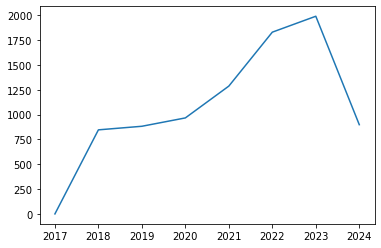

In [9]:
# explore counts per year
df.INC_DATE.dt.year.value_counts().sort_index().plot()

In [10]:
# exclude values from 2017 since there are so few
df = df[(df.INC_DATE >= pd.to_datetime('2018-01-01')) & 
         (df.INC_DATE < pd.to_datetime('2024-01-01'))]

In [11]:
df.shape

(7796, 24)

## Prepare/filter data

In [12]:
# rename columns based on numerical 
# ordering from ChatGPT
citizen_rename = dict(zip(['CIT_RESIST_NONE', 'CIT_RESIST_VRBL_NONCOMPLIANCE',
       'CIT_RESIST_PSYCH_INTIMIDATION', 'CIT_RESIST_PASSIVE_RESISTANCE',
       'CIT_RESIST_ACTIVE_RESISTANCE', 'CIT_RESIST_ACTIVE_AGGRESSN',
       'CIT_RESIST_AGG_ACTIV_AGGRESSN', 'SUBJ_ARMED_BODY_FORCE',
       'SUBJ_ARMED_BLUNT_INSTRMT', 'SUBJ_ARMED_CUTTING_INSTRMT',
       'SUBJ_ARMED_GUN'],
   ['1. CIT_RESIST_NONE', '2. CIT_RESIST_VRBL_NONCOMPLIANCE',
       '3. CIT_RESIST_PSYCH_INTIMIDATION',
       '4. CIT_RESIST_PASSIVE_RESISTANCE',
       '5. CIT_RESIST_ACTIVE_RESISTANCE', '6. CIT_RESIST_ACTIVE_AGGRESSN',
       '7. CIT_RESIST_AGG_ACTIV_AGGRESSN', '8. SUBJ_ARMED_BODY_FORCE',
       '9. SUBJ_ARMED_BLUNT_INSTRMT', '10. SUBJ_ARMED_CUTTING_INSTRMT',
       '11. SUBJ_ARMED_GUN']))

force_rename = dict(zip(['FORCE_RESTRAINTS', 'FORCE_SOFT_EMPTY_HAND', 'FORCE_PGP',
       'FORCE_TRIP_TACKLE', 'FORCE_HARD_EMPTY_HAND',
       'FORCE_CHEMICAL_AGENTS', 'FORCE_ECD', 'FORCE_IMPACT_WEAPONS',
       'FORCE_IMPACT_MUNITIONS', 'FORCE_CANINE', 'FORCE_LETHAL'],
   ['1. FORCE_RESTRAINTS', '2. FORCE_SOFT_EMPTY_HAND', '3. FORCE_PGP',
       '4. FORCE_TRIP_TACKLE', '5. FORCE_HARD_EMPTY_HAND',
       '6. FORCE_CHEMICAL_AGENTS', '7. FORCE_ECD',
       '8. FORCE_IMPACT_WEAPONS', '9. FORCE_IMPACT_MUNITIONS',
       '10. FORCE_CANINE', '11. FORCE_LETHAL']))

In [13]:
# unpivot data
df = df.melt(id_vars=['INC_IR_NO', 'INC_DATE'])

# retain data that provides information on each incident
df = df[df.value=='Yes'].drop('value', axis=1)

In [14]:
df.shape

(36494, 3)

In [15]:
# create column identifiers for citizen and force
# using the dictionaries I created above
df['citizen'] = df.variable.isin(citizen_rename.keys())

df['force'] = df.variable.isin(force_rename.keys())

In [16]:
df.shape

(36494, 5)

In [17]:
# replace values using the dictionaries I created above
df.variable = df.variable.replace(citizen_rename).replace(force_rename)

In [18]:
df.shape

(36494, 5)

In [19]:
# convert rank column to integer
df['rank'] = df.variable.str.split('.').str[0].astype(int)

In [20]:
df.head()

INC_IR_NO   INC_DATE                          variable  citizen  \
2   201800000002889 2018-01-01  7. CIT_RESIST_AGG_ACTIV_AGGRESSN     True   
21  201800000030903 2018-01-06  7. CIT_RESIST_AGG_ACTIV_AGGRESSN     True   
23  201800000043352 2018-01-08  7. CIT_RESIST_AGG_ACTIV_AGGRESSN     True   
24  201800000043352 2018-01-08  7. CIT_RESIST_AGG_ACTIV_AGGRESSN     True   
32  201800000057014 2018-01-10  7. CIT_RESIST_AGG_ACTIV_AGGRESSN     True   

    force  rank  
2   False     7  
21  False     7  
23  False     7  
24  False     7  
32  False     7

## Force Trend Plot

In [21]:
alt.Chart(df[df.force == True]).mark_area().encode(
alt.X('yearmonth(INC_DATE):T', axis=alt.Axis(title='')),
alt.Y('count(variable)', axis=alt.Axis(title='')).stack('normalize'),
alt.Color('variable', ),
order=alt.Order('variable:O', sort='ascending')
).properties(
    width=600,
    height=200,
    title='PERCENT BY MONTH'
)

alt.Chart(...)

In [22]:
alt.Chart(df[df.citizen == True]).mark_area().encode(
alt.X('yearmonth(INC_DATE):T', axis=alt.Axis(title='')),
alt.Y('count(variable)', axis=alt.Axis(title='')).stack('normalize'),
alt.Color('variable', ),
order=alt.Order('variable:O', sort='ascending')
).properties(
    width=600,
    height=200,
    title='PERCENT BY MONTH'
)

alt.Chart(...)

## Citizen vs. Force Comparison Plot

In [23]:
# prepare data
max_per_incident = df.melt(id_vars=['INC_IR_NO', 'rank', 'INC_DATE'], value_vars=['citizen', 'force'], var_name='citizen_force')

max_per_incident = max_per_incident[max_per_incident.value]

max_per_incident = max_per_incident.drop('value', axis=1)

In [24]:
max_per_incident.head()

INC_IR_NO  rank   INC_DATE citizen_force
0  201800000002889     7 2018-01-01       citizen
1  201800000030903     7 2018-01-06       citizen
2  201800000043352     7 2018-01-08       citizen
3  201800000043352     7 2018-01-08       citizen
4  201800000057014     7 2018-01-10       citizen

In [25]:
# find max resistance and force per incident
max_per_incident = max_per_incident.groupby(['INC_IR_NO', 'INC_DATE', 'citizen_force'])['rank'].max().rename('max_rank').reset_index().pivot(index=['INC_IR_NO', 'INC_DATE'], columns='citizen_force')

max_per_incident = max_per_incident.droplevel(0, axis=1).reset_index()

In [26]:
# find numerical difference between force and citizen resistance
max_per_incident['citizen_force_diff'] = (max_per_incident.force - max_per_incident.citizen)

In [27]:
# exclude diff rows that have no value
# not clear to me why there would not be at least one
# resistance category and one force category
max_per_incident = max_per_incident.dropna()

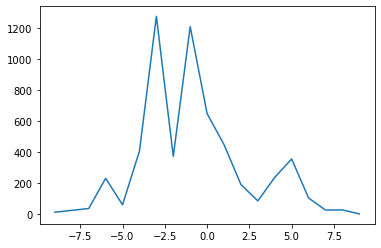

In [28]:
# explore distribution of diff
max_per_incident.citizen_force_diff.value_counts(dropna=False).sort_index().plot();

## Create charts

In [29]:
# Define area count chart
month_count = alt.Chart(max_per_incident).mark_area().encode(
    alt.X('yearmonth(INC_DATE):T', axis=alt.Axis(title='', labels=False, tickCount="year", tickSize=10, grid=True, gridDash=[2, 2])),
    alt.Y('count(citizen_force_diff)', axis=alt.Axis(title='', grid=True, gridDash=[2, 2])),
    alt.Color('citizen_force_diff:Q', scale=alt.Scale(scheme='blueorange'), legend=None),
    order=alt.Order('citizen_force_diff:Q', sort='ascending')
).properties(
    width=600,
    height=200,
    title='USE OF FORCE INCIDENTS EACH MONTH (Phoenix AZ)'
)

# Define area percent chart
month_percent = alt.Chart(max_per_incident).mark_area().encode(
    alt.X('yearmonth(INC_DATE):T', axis=alt.Axis(title='', format="%Y", tickCount="year", tickSize=10)),
    alt.Y('count(citizen_force_diff)', axis=alt.Axis(title='')).stack('normalize'),
    alt.Color('citizen_force_diff:Q', scale=alt.Scale(scheme='blueorange'), legend=None),
    order=alt.Order('citizen_force_diff:Q', sort='ascending')
).properties(
    width=600,
    height=200,
    title='USE OF FORCE INCIDENTS AS PERCENT EACH MONTH (Phoenix AZ)'
)


area_plots = alt.hconcat(alt.vconcat(month_count, month_percent))

area_plots

alt.HConcatChart(...)

## Create legend

In [30]:
# Sample data for the gradient
gradient_data = pd.DataFrame({'gradient_data': np.linspace(0, 1, 1000)})

# Create the gradient rectangle
gradient = alt.Chart(gradient_data).mark_rect().encode(
    alt.Y('gradient_data:Q', axis=None, bin=alt.Bin(maxbins=100)),
    alt.Color('gradient_data:Q', scale=alt.Scale(scheme='blueorange'), legend=None)
).properties(
    width=20,
    height=200
)

# Add text annotations to the gradient
low_text = alt.Chart(pd.DataFrame({'text': [['▲',
                                             'Higher',
                                             'Force', 
                                           'vs.',
                                             'Citizen', 
                                           'Resistance']]})).mark_text(
    align='left',
    baseline='middle',
    dx=0,
    dy=15,
    color='black',
    fontSize=15,
).encode(
    x=alt.value(25),
    y=alt.value(0),
    text='text:N'
)

high_text = alt.Chart(pd.DataFrame({'text': [['Lower',
                                              'Force', 
                                               'vs.',
                                              'Citizen', 
                                               'Resistance',
                                             '▼']]})).mark_text(
    align='left',
    baseline='middle',
    dx=0,
    dy=-90,
    color='black',
    fontSize=15
).encode(
    x=alt.value(25),
    y=alt.value(450),
    text='text:N'
)

# Combine the gradient and text annotations
custom_legend = alt.layer(gradient, low_text, high_text).properties(
    width=20,
    height=455
)

custom_legend

alt.LayerChart(...)

In [31]:
# Concatenate the charts vertically
combined_chart = alt.hconcat(area_plots, custom_legend).resolve_scale(
    color='independent'
).configure_title(
    fontSize=16  # Set the title font size
).display(
    scaleFactor=3
)

combined_chart

alt.HConcatChart(...)

## Examine specific cases

In [32]:
characteristics_per_incident = df[['INC_IR_NO', 'variable']].groupby(['INC_IR_NO']).variable.agg(', '.join).rename('characteristic_string').reset_index()

In [33]:
characteristics_per_incident.sort_values('INC_IR_NO').head()

INC_IR_NO  \
0    2020002038585   
1  201700001616073   
2  201700001931734   
3  201700002192931   
4  201800000000821   

                                                                                                                                  characteristic_string  
0                                                                               5. CIT_RESIST_ACTIVE_RESISTANCE, 5. FORCE_HARD_EMPTY_HAND, 7. FORCE_ECD  
1                                                                                           2. CIT_RESIST_VRBL_NONCOMPLIANCE, 9. FORCE_IMPACT_MUNITIONS  
2                        5. CIT_RESIST_ACTIVE_RESISTANCE, 3. CIT_RESIST_PSYCH_INTIMIDATION, 2. CIT_RESIST_VRBL_NONCOMPLIANCE, 9. FORCE_IMPACT_MUNITIONS  
3                                                              6. CIT_RESIST_ACTIVE_AGGRESSN, 5. CIT_RESIST_ACTIVE_RESISTANCE, 5. FORCE_HARD_EMPTY_HAND  
4  6. CIT_RESIST_ACTIVE_AGGRESSN, 5. CIT_RESIST_ACTIVE_RESISTANCE, 3. CIT_RESIST_PSYCH_INTIMIDATION, 5. FORCE_HARD_EMPTY_HAND, 2. FORCE_SOFT_EMPTY_HAND

In [34]:
max_per_incident.merge(characteristics_per_incident).sort_values('citizen_force_diff').tail()

INC_IR_NO   INC_DATE  citizen  force  citizen_force_diff  \
85    201800000228973 2018-02-07      2.0   10.0                 8.0   
83    201800000225090 2018-02-23      2.0   10.0                 8.0   
36    201800000073807 2018-01-13      2.0   10.0                 8.0   
854   201900000564191 2019-04-05      2.0   10.0                 8.0   
1872  202000001458412 2020-09-04      2.0   11.0                 9.0   

                                                                                                                                           characteristic_string  
85                                                                                  2. CIT_RESIST_VRBL_NONCOMPLIANCE, 10. FORCE_CANINE, 2. FORCE_SOFT_EMPTY_HAND  
83                                                                                  2. CIT_RESIST_VRBL_NONCOMPLIANCE, 10. FORCE_CANINE, 2. FORCE_SOFT_EMPTY_HAND  
36                                                                                  2. CIT_RESIST_VRBL_NONCOMPLIANCE, 10. FORCE_CANINE, 2. FORCE_SOFT_EMPTY_HAND  
854                                                                                                           2. CIT_RESIST_VRBL_NONCOMPLIANCE, 10. FORCE_CANINE  
1872  2. CIT_RESIST_VRBL_NONCOMPLIANCE, 2. CIT_RESIST_VRBL_NONCOMPLIANCE, 11. FORCE_LETHAL, 10. FORCE_CANINE, 2. FORCE_SOFT_EMPTY_HAND, 2. FORCE_SOFT_EMPTY_HAND